In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime

In [ ]:
air = pd.read_csv(r"C:\Users\jeeve\Desktop\PGC\Course 6 ML\project\Airbnb_data - airbnb_data.csv")

In [4]:
air.info()
air.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      74111 non-null  int64  
 1   log_price               74111 non-null  float64
 2   property_type           74111 non-null  object 
 3   room_type               74111 non-null  object 
 4   amenities               74111 non-null  object 
 5   accommodates            74111 non-null  int64  
 6   bathrooms               73911 non-null  float64
 7   bed_type                74111 non-null  object 
 8   cancellation_policy     74111 non-null  object 
 9   cleaning_fee            74111 non-null  bool   
 10  city                    74111 non-null  object 
 11  description             74111 non-null  object 
 12  first_review            58247 non-null  object 
 13  host_has_profile_pic    73923 non-null  object 
 14  host_identity_verified  73923 non-null

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,...,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,...,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,...,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,...,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,...,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


In [ ]:
num_cols = air.select_dtypes(include=['number']).columns.tolist()
num_cols.remove("log_price")  # Ensure target variable is not included
air[num_cols] = air[num_cols].apply(lambda col: col.fillna(col.median()))

air.drop(columns=["description", "name", "thumbnail_url"], inplace=True, errors="ignore")

cat_cols = air.select_dtypes(include=['object']).columns.tolist()
air[cat_cols] = air[cat_cols].apply(lambda col: col.fillna(col.mode()[0]))

In [ ]:
air["host_has_profile_pic"] = air["host_has_profile_pic"].map({"t": 1, "f": 0})
air["host_identity_verified"] = air["host_identity_verified"].map({"t": 1, "f": 0})
air["instant_bookable"] = air["instant_bookable"].map({"t": 1, "f": 0})

In [ ]:
date_cols = ["first_review", "last_review", "host_since"]
current_year = datetime.now().year
for col in date_cols:
    if col in air.columns:
        air[col] = pd.to_datetime(air[col], format='%d-%m-%Y', errors='coerce')
        air[col] = air[col].apply(lambda x: current_year - x.year if pd.notnull(x) else 0)

In [ ]:
if "amenities" in air.columns:
    air["amenities_count"] = air["amenities"].apply(lambda x: len(str(x).split(',')))
    air.drop(columns=["amenities"], inplace=True, errors="ignore")

air.drop(columns=["description", "name", "thumbnail_url"], inplace=True, errors="ignore")

In [13]:
cat_cols = [col for col in cat_cols if col in air.columns]
air[cat_cols] = air[cat_cols].astype(str)

In [ ]:
high_cardinality_cols = [col for col in cat_cols if air[col].nunique() > 10]
low_cardinality_cols = list(set(cat_cols) - set(high_cardinality_cols))

label_encoders = {}
for col in high_cardinality_cols:
    le = LabelEncoder()
    air[col] = le.fit_transform(air[col])
    label_encoders[col] = le

In [ ]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=np.float64)
if low_cardinality_cols:
    encoded_features = pd.DataFrame(encoder.fit_transform(air[low_cardinality_cols]))
    encoded_features.columns = encoder.get_feature_names_out(low_cardinality_cols)
    air.drop(columns=low_cardinality_cols, inplace=True)
    air = pd.concat([air, encoded_features], axis=1)

In [16]:
air = air.apply(pd.to_numeric, errors='coerce')

In [18]:
X = air.drop(columns=['log_price'])
y = air['log_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
num_features = [col for col in X_train.columns if col not in high_cardinality_cols + list(encoded_features.columns)]

In [ ]:
scaler = StandardScaler()
num_features = [col for col in X_train.columns if col not in high_cardinality_cols + list(encoded_features.columns)]

In [21]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [22]:
y_pred = model.predict(X_test)

In [23]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

In [24]:
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")

MAE: 0.2825633699405822
RMSE: 0.392525334711719
R² Score: 0.7000810377290807


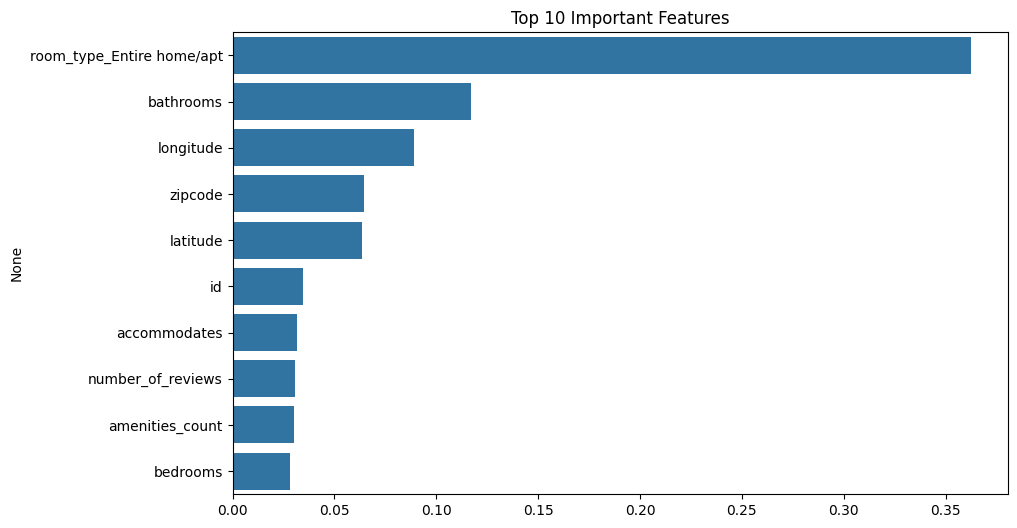

In [25]:
feature_importance = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance.values[:10], y=feature_importance.index[:10])
plt.title("Top 10 Important Features")
plt.show()

In [26]:
import os
video_link = "https://drive.google.com/file/d/1gw6rcNgKf_7OhTTaF9KSRwFE5qo1oQrG/view?usp=drive_link"
file_name = "Video_Link.txt"

with open(file_name, "w") as file:
    file.write(f"Project Video Link -  {video_link}")

print("Video explanation link saved successfully")
print(f" Video Explanation Link: {video_link}")

if os.path.exists(file_name):
    print("File created successfully with video link.")
else:
    print("Error in creating the file.")



Video explanation link saved successfully
 Video Explanation Link: https://drive.google.com/file/d/1gw6rcNgKf_7OhTTaF9KSRwFE5qo1oQrG/view?usp=drive_link
File created successfully with video link.
